# An Empirical Study of Information State Depth and Markovity in Partialy Observed Paper Tennis

The purpose of this notebook is to explore the value of verious depth information states for a tabular Q-learning Reinforcement Learning agent in a prtially observed Paper Tennis  gym environment. Rules of the game can be found in the environment files (PaperTennis_env.py), and a report will be attached in the repo eventually detailing the background and results. 

## Imports and Setup

In [1]:
# Library imports
from PaperTennis_env import PaperTennisEnv
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from tqdm import tqdm
import pandas as pd
import seaborn as sns


In [2]:
# Setup 
#Hyperparms
STRATEGY = 'Naive' # Modified for each of 5 startegies
GAMMA = 0.9
ALPHA = 0.2
E_GREEDY = 0.05
NUM_EPISODES = 4000000
OPP_FREQ = 1
mean_window = 10000

# Get Strategy index
Strategies = {
    'Mean': 1,
    'Long': 2,
    'Short': 3,
    'Naive': 4,
    'Random': 5
}

# Generate opponent strategy vector
if Strategies[STRATEGY] == 5:
    OPP_Strat = np.around(np.random.uniform(1,4,int(NUM_EPISODES/OPP_FREQ)))
    OPP_Strat = np.repeat(OPP_Strat, OPP_FREQ)
else: 
    OPP_Strat = np.repeat(Strategies[STRATEGY], NUM_EPISODES)

In [3]:
# Get action e-greedy
def get_action(state,Q_val):
    if state[1] == 0:
        return 0

    p_epsilon = np.random.uniform(0,1)
    if p_epsilon < E_GREEDY:
        return np.argmax(np.random.uniform(0,1,(1,state[1]))) + 1

    q_s = np.zeros(state[1])

    for i in range(1,state[1]):
        if len(state)==3: q_s[i] = Q_val[state[0],state[1],state[2],i]
        if len(state)==4: q_s[i] = Q_val[state[0],state[1],state[2],state[3],i]
        if len(state)==5: q_s[i] = Q_val[state[0],state[1],state[2],state[3],state[4],i]
        if len(state)==7: q_s[i] = Q_val[state[0],state[1],state[2],state[3],state[4],state[5],state[6],i]

    return np.argmax(q_s) + 1

## Baseline
### Fully Observed Environment Agent

In [4]:
'''
Baseline
'''

# Init Q table and train history
Q_val = np.zeros([5,51,51,50])

# Init Env
env = PaperTennisEnv()

# Plotting Stuff
wins = np.zeros(NUM_EPISODES)

for episode in tqdm(range(NUM_EPISODES)):

    env.reset(OPP_Strat[episode])
    state = env.state
    done = False

    action = get_action(state,Q_val)

    # Generate an episode
    error_episode = 0
    while not done:
        # Step Environment
        state_prime, reward, done, info = env.step(action)

        # Get Action e-greedy 
        action_prime = get_action(state_prime,Q_val)
        

        # SARSA tabular update (Section 6.5 S.B., psuedocode)
        TD_error = (reward + GAMMA * Q_val[state_prime[0],state_prime[1],state_prime[2],action_prime-1]
            -Q_val[state[0],state[1],state[2],action-1])

        Q_val[state[0],state[1],state[2],action-1] = Q_val[state[0],state[1],state[2],action-1] + ALPHA*TD_error

        error_episode += abs(TD_error)

        state  = state_prime
        action = action_prime


    # Track progress
    if reward == 1: wins[episode] = 1

# Save Training Results
np.save('/Users/sunaybhat/Documents/GitHub/Footsteps-Tennis_CIRL/Data/SARSA_QT/Markovity/' + 'Basline_{}_Wins.npy'.format(STRATEGY),wins)

# Print run details
print('Final mean win percent = {:.2f}%'.format(np.sum(wins[-10000:])/100))

100%|██████████| 4000000/4000000 [14:17<00:00, 4665.87it/s]


Final mean win percent = 88.81%


## Parially Observability with Varying Memory Depth

In [5]:
'''
Last Win/Loss
'''

# Init Q table and train history
Q_val = np.zeros([5,51,2,50])

# Init Env
env = PaperTennisEnv()

# Plotting Stuff
wins = np.zeros(NUM_EPISODES)

for episode in tqdm(range(NUM_EPISODES)):

    env.reset(OPP_Strat[episode])
    state = env.state
    state_PO = (state[0],state[1],0)
    done = False

    action = get_action(state_PO,Q_val)

    # Generate an episode
    error_episode = 0
    while not done:
        # Step Environment
        state_prime, reward, done, _ = env.step(action)
        if state_prime[0] > 0: state_prime_PO = (state_prime[0],state_prime[1],1)
        else: state_prime_PO = (state_prime[0],state_prime[1],0)

        # Get Action e-greedy 
        action_prime = get_action(state_prime_PO,Q_val)
        

        # SARSA tabular update (Section 6.5 S.B., psuedocode)
        TD_error = (reward + GAMMA * Q_val[state_prime_PO[0],state_prime_PO[1],state_prime_PO[2],action_prime-1]
            -Q_val[state_PO[0],state_PO[1],state_PO[2],action-1])

        Q_val[state_PO[0],state_PO[1],state_PO[2],action-1] = Q_val[state_PO[0],state_PO[1],state_PO[2],action-1] + ALPHA*TD_error

        state_PO  = state_prime_PO
        action = action_prime

    # Track progress
    if reward == 1: wins[episode] = 1
            


# Save Training Results
np.save('/Users/sunaybhat/Documents/GitHub/Footsteps-Tennis_CIRL/Data/SARSA_QT/Markovity/' + 'LastWL_{}_Wins.npy'.format(STRATEGY),wins)

# Print run details
print('Final mean win percent = {:.2f}%'.format(np.sum(wins[-10000:])/100))

100%|██████████| 4000000/4000000 [15:00<00:00, 4439.97it/s]

Final mean win percent = 86.01%


In [6]:
'''
Last 2 Win/Loss
'''

# Init Q table and train history
Q_val = np.zeros([5,51,3,3,50])

# Init Env
env = PaperTennisEnv()

# Plotting Stuff
wins = np.zeros(NUM_EPISODES)

for episode in tqdm(range(NUM_EPISODES)):

    env.reset(OPP_Strat[episode])
    state = env.state
    
    WL_memory = np.zeros(2)
    
    for iMem,iWL in enumerate(reversed(info['round history'])):
        WL_memory[iMem] = iWL+1
        if iMem == 1: break

    state_PO = (state[0],state[1],int(WL_memory[0]),int(WL_memory[1]))
    done = False

    action = get_action(state_PO,Q_val)

    # Generate an episode
    error_episode = 0
    while not done:
        # Step Environment
        state_prime, reward, done, info = env.step(action)
        WL_memory = np.zeros(2)
        for iMem,iWL in enumerate(reversed(info['round history'])): 
            WL_memory[iMem] = iWL+1
            if iMem == 1: break
            
        state_prime_PO = (state_prime[0],state_prime[1],int(WL_memory[0]),int(WL_memory[1]))

        # Get Action e-greedy 
        action_prime = get_action(state_prime_PO,Q_val)
        

        # SARSA tabular update (Section 6.5 S.B., psuedocode)
        TD_error = (reward + GAMMA * Q_val[state_prime_PO[0],state_prime_PO[1],state_prime_PO[2],state_prime_PO[3],action_prime-1]
            -Q_val[state_PO[0],state_PO[1],state_PO[2],state_PO[3],action-1])

        Q_val[state_PO[0],state_PO[1],state_PO[2],state_PO[3],action-1] = Q_val[state_PO[0],state_PO[1],state_PO[2],state_PO[3],action-1] + ALPHA*TD_error

        state_PO  = state_prime_PO
        action = action_prime

    # Track progress
    if reward == 1: wins[episode] = 1
            


# Save Training Results
np.save('/Users/sunaybhat/Documents/GitHub/Footsteps-Tennis_CIRL/Data/SARSA_QT/Markovity/' + 'Last2WL_{}_Wins.npy'.format(STRATEGY),wins)

# Print run details
print('Final mean win percent = {:.2f}%'.format(np.sum(wins[-10000:])/100))

100%|██████████| 4000000/4000000 [16:22<00:00, 4069.67it/s]

Final mean win percent = 87.00%


In [7]:
'''
Last 3 Win/Loss
'''

# Init Q table and train history
Q_val = np.zeros([5,51,3,3,3,50])

# Init Env
env = PaperTennisEnv()

# Plotting Stuff
wins = np.zeros(NUM_EPISODES)

for episode in tqdm(range(NUM_EPISODES)):

    env.reset(OPP_Strat[episode])
    state = env.state
    
    WL_memory = np.zeros(3)
    
    for iMem,iWL in enumerate(reversed(info['round history'])):
        WL_memory[iMem] = iWL+1
        if iMem == 2: break

    state_PO = (state[0],state[1],int(WL_memory[0]),int(WL_memory[1]),int(WL_memory[2]))
    done = False

    action = get_action(state_PO,Q_val)

    # Generate an episode
    error_episode = 0
    while not done:
        # Step Environment
        state_prime, reward, done, info = env.step(action)
        WL_memory = np.zeros(3)
        for iMem,iWL in enumerate(reversed(info['round history'])): 
            WL_memory[iMem] = iWL+1
            if iMem == 2: break
            
        state_prime_PO = (state_prime[0],state_prime[1],int(WL_memory[0]),int(WL_memory[1]),int(WL_memory[2]))

        # Get Action e-greedy 
        action_prime = get_action(state_prime_PO,Q_val)
        

        # SARSA tabular update (Section 6.5 S.B., psuedocode)
        TD_error = (reward + GAMMA * Q_val[state_prime_PO[0],state_prime_PO[1],state_prime_PO[2],state_prime_PO[3],state_prime_PO[4],action_prime-1]
            -Q_val[state_PO[0],state_PO[1],state_PO[2],state_PO[3],state_PO[4],action-1])

        Q_val[state_PO[0],state_PO[1],state_PO[2],state_PO[3],state_PO[4],action-1] = Q_val[state_PO[0],state_PO[1],state_PO[2],state_PO[3],state_PO[4],action-1] + ALPHA*TD_error

        state_PO  = state_prime_PO
        action = action_prime

    # Track progress
    if reward == 1: wins[episode] = 1
            


# Save Training Results
np.save('/Users/sunaybhat/Documents/GitHub/Footsteps-Tennis_CIRL/Data/SARSA_QT/Markovity/' + 'Last3WL_{}_Wins.npy'.format(STRATEGY),wins)

# Print run details
print('Final mean win percent = {:.2f}%'.format(np.sum(wins[-10000:])/100))

100%|██████████| 4000000/4000000 [17:12<00:00, 3872.58it/s]

Final mean win percent = 89.86%


In [8]:
'''
Last 5 Win/Loss
'''

# Init Q table and train history
Q_val = np.zeros([5,51,3,3,3,3,3,50])

# Init Env
env = PaperTennisEnv()

# Plotting Stuff
wins = np.zeros(NUM_EPISODES)

for episode in tqdm(range(NUM_EPISODES)):

    env.reset(OPP_Strat[episode])
    state = env.state
    
    WL_memory = np.zeros(5)
    
    for iMem,iWL in enumerate(reversed(info['round history'])):
        WL_memory[iMem] = iWL+1
        if iMem == 4: break

    state_PO = (state[0],state[1],int(WL_memory[0]),int(WL_memory[1]),int(WL_memory[2]),int(WL_memory[3]),int(WL_memory[4]))
    done = False

    action = get_action(state_PO,Q_val)

    # Generate an episode
    error_episode = 0
    while not done:
        # Step Environment
        state_prime, reward, done, info = env.step(action)
        WL_memory = np.zeros(5)
        for iMem,iWL in enumerate(reversed(info['round history'])): 
            WL_memory[iMem] = iWL+1
            if iMem == 4: break
            
        state_prime_PO = (state_prime[0],state_prime[1],int(WL_memory[0]),int(WL_memory[1]),int(WL_memory[2]),int(WL_memory[3]),int(WL_memory[4]))

        # Get Action e-greedy 
        action_prime = get_action(state_prime_PO,Q_val)
        

        # SARSA tabular update (Section 6.5 S.B., psuedocode)
        TD_error = (reward + GAMMA * Q_val[state_prime_PO[0],state_prime_PO[1],state_prime_PO[2],state_prime_PO[3],state_prime_PO[4],state_prime_PO[5],state_prime_PO[6],action_prime-1]
            -Q_val[state_PO[0],state_PO[1],state_PO[2],state_PO[3],state_PO[4],state_PO[5],state_PO[6],action-1])

        Q_val[state_PO[0],state_PO[1],state_PO[2],state_PO[3],state_PO[4],state_PO[5],state_PO[6],action-1] = \
            Q_val[state_PO[0],state_PO[1],state_PO[2],state_PO[3],state_PO[4],state_PO[5],state_PO[6],action-1] + ALPHA*TD_error

        state_PO  = state_prime_PO
        action = action_prime

    # Track progress
    if reward == 1: wins[episode] = 1
            


# Save Training Results
np.save('/Users/sunaybhat/Documents/GitHub/Footsteps-Tennis_CIRL/Data/SARSA_QT/Markovity/' + 'Last5WL_{}_Wins.npy'.format(STRATEGY),wins)

# Print run details
print('Final mean win percent = {:.2f}%'.format(np.sum(wins[-10000:])/100))

100%|██████████| 4000000/4000000 [51:55<00:00, 1283.77it/s]


Final mean win percent = 93.14%


# Analysis

In [12]:
win_results = {}
win_converge = {}

In [13]:
# Read in and generate win trajectories (raw and 10k avg)
STRATEGY = 'Naive'
mean_window = 10000

wins_baseline = np.load('/Users/sunaybhat/Documents/GitHub/Footsteps-Tennis_CIRL/Data/SARSA_QT/Markovity/' + 'Basline_{}_Wins.npy'.format(STRATEGY))
wins_depth1 = np.load('/Users/sunaybhat/Documents/GitHub/Footsteps-Tennis_CIRL/Data/SARSA_QT/Markovity/' + 'LastWL_{}_Wins.npy'.format(STRATEGY))
wins_depth2 = np.load('/Users/sunaybhat/Documents/GitHub/Footsteps-Tennis_CIRL/Data/SARSA_QT/Markovity/' + 'Last2WL_{}_Wins.npy'.format(STRATEGY))
wins_depth3 = np.load('/Users/sunaybhat/Documents/GitHub/Footsteps-Tennis_CIRL/Data/SARSA_QT/Markovity/' + 'Last3WL_{}_Wins.npy'.format(STRATEGY))
wins_depth5 = np.load('/Users/sunaybhat/Documents/GitHub/Footsteps-Tennis_CIRL/Data/SARSA_QT/Markovity/' + 'Last5WL_{}_Wins.npy'.format(STRATEGY))


win100_baseline = np.flip(np.convolve(np.flip(wins_baseline), np.ones(100), mode='valid'))
win100_depth1 = np.flip(np.convolve(np.flip(wins_depth1), np.ones(100), mode='valid'))
win100_depth2 = np.flip(np.convolve(np.flip(wins_depth2), np.ones(100), mode='valid'))
win100_depth3 = np.flip(np.convolve(np.flip(wins_depth3), np.ones(100), mode='valid'))
win100_depth5 = np.flip(np.convolve(np.flip(wins_depth5), np.ones(100), mode='valid'))

win_avg_baseline = np.flip(np.convolve(np.flip(win100_baseline), np.ones(mean_window)/mean_window, mode='valid'))
win_avg_depth1 = np.flip(np.convolve(np.flip(win100_depth1), np.ones(mean_window)/mean_window, mode='valid'))
win_avg_depth2 = np.flip(np.convolve(np.flip(win100_depth2), np.ones(mean_window)/mean_window, mode='valid'))
win_avg_depth3 = np.flip(np.convolve(np.flip(win100_depth3), np.ones(mean_window)/mean_window, mode='valid'))
win_avg_depth5 = np.flip(np.convolve(np.flip(win100_depth5), np.ones(mean_window)/mean_window, mode='valid'))

win_results[STRATEGY] = [np.sum(wins_baseline[-10000:])/100,np.sum(wins_depth1[-10000:])/100,np.sum(wins_depth2[-10000:])/100,np.sum(wins_depth3[-10000:])/100,\
    np.sum(wins_depth5[-10000:])/100]

win_converge[STRATEGY] = [np.argmax(win100_baseline>(.9 * win_results[STRATEGY][0])),np.argmax(win100_depth1>(.9 * win_results[STRATEGY][1])),\
    np.argmax(win100_depth2>(.9 * win_results[STRATEGY][2])),np.argmax(win100_depth3>(.9 * win_results[STRATEGY][3])),np.argmax(win100_depth5>(.9 * win_results[STRATEGY][4]))]

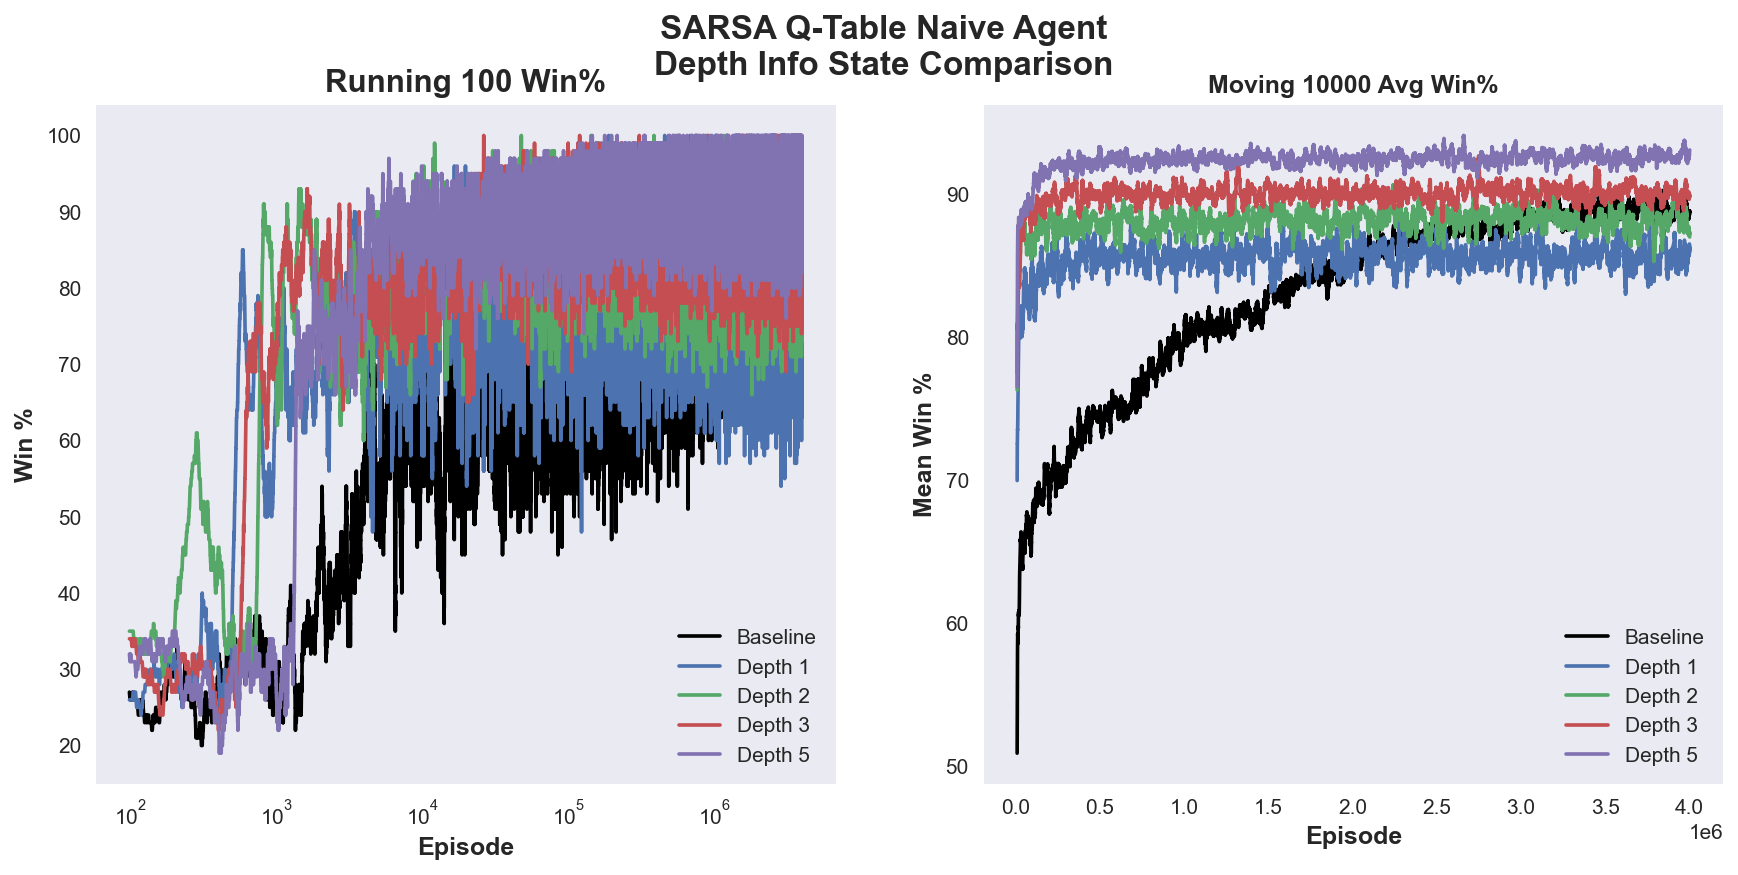

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(14,6), dpi= 150, facecolor='w', edgecolor='k')
fig.suptitle('SARSA Q-Table {} Agent\nDepth Info State Comparison'.format(STRATEGY),fontweight='bold',fontsize = 16)

ax1.plot(range(99,NUM_EPISODES),win100_baseline, c='k',label="Baseline")
ax1.plot(range(99,NUM_EPISODES),win100_depth1, label="Depth 1")
ax1.plot(range(99,NUM_EPISODES),win100_depth2, label="Depth 2")
ax1.plot(range(99,NUM_EPISODES),win100_depth3, label="Depth 3")
ax1.plot(range(99,NUM_EPISODES),win100_depth5, label="Depth 5")
ax1.set_title('Running 100 Win%',fontweight='bold',fontsize = 15)
ax1.set_xlabel('Episode',fontweight='bold',fontsize = 12)
ax1.set_ylabel('Win %',fontweight='bold',fontsize = 12)
ax1.legend()
ax1.set_xscale('log')
ax1.grid()

ax2.plot(range(mean_window-1,len(win100_baseline)), win_avg_baseline, c='k',label="Baseline")
ax2.plot(range(mean_window-1,len(win100_depth1)), win_avg_depth1, label="Depth 1")
ax2.plot(range(mean_window-1,len(win100_depth2)), win_avg_depth2, label="Depth 2")
ax2.plot(range(mean_window-1,len(win100_depth3)), win_avg_depth3, label="Depth 3")
ax2.plot(range(mean_window-1,len(win100_depth5)), win_avg_depth5, label="Depth 5")
ax2.set_title('Moving 10000 Avg Win%', fontweight='bold',fontsize = 12)
ax2.set_xlabel('Episode', fontweight='bold',fontsize = 12)
ax2.set_ylabel('Mean Win %', fontweight='bold',fontsize = 12)
ax2.legend()
ax2.grid()

fig.savefig('/Users/sunaybhat/Documents/GitHub/Footsteps-Tennis_CIRL/Data/SARSA_QT/Markovity/' + 'Train_{}.png'.format(STRATEGY))


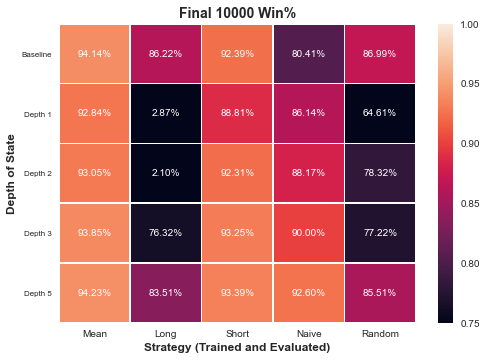

In [ ]:
results = pd.DataFrame.from_dict(win_results)
results.index = ['Baseline','Depth 1','Depth 2','Depth 3','Depth 5']

ax3 = plt.axes()
g = sns.heatmap(results/100,vmin=.75, vmax=1,linewidths=.5,annot=True,fmt=".2%",ax=ax3)
ax3.set_title('Final 10000 Win%', fontweight='bold',fontsize = 14)
ax3.set_xlabel('Strategy (Trained and Evaluated)', fontweight='bold',fontsize = 12)
ax3.set_ylabel('Depth of State', fontweight='bold',fontsize = 12)
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 8)

figure = g.get_figure()    
figure.savefig('/Users/sunaybhat/Documents/GitHub/Footsteps-Tennis_CIRL/Data/SARSA_QT/Markovity/Win_Results.png', dpi=400)

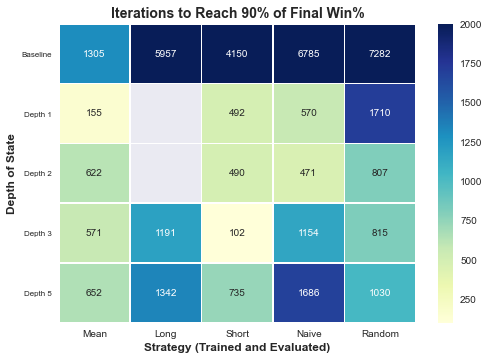

In [ ]:
converge = pd.DataFrame.from_dict(win_converge)
converge.index = ['Baseline','Depth 1','Depth 2','Depth 3','Depth 5']

ax4 = plt.axes()
g = sns.heatmap(converge+100,linewidths=.5,vmin=100, vmax=2000,annot=True,fmt="d",cmap="YlGnBu",ax=ax4,mask=(results < 50))
ax4.set_title('Iterations to Reach 90% of Final Win%', fontweight='bold',fontsize = 14)
ax4.set_xlabel('Strategy (Trained and Evaluated)', fontweight='bold',fontsize = 12)
ax4.set_ylabel('Depth of State', fontweight='bold',fontsize = 12)
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 8)

figure = g.get_figure()    
figure.savefig('/Users/sunaybhat/Documents/GitHub/Footsteps-Tennis_CIRL/Data/SARSA_QT/Markovity/Win_Converge.png', dpi=400)

In [15]:
win_results

{'Naive': [88.81, 86.01, 87.0, 89.86, 93.14]}